<a href="https://colab.research.google.com/github/lallapalooza91/APS360-Final-Project/blob/main/Lab2_Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

In [ ]:
%%shell
jupyter nbconvert --to html "/content/Lab2_Cats_vs_Dogs.ipynb"

[NbConvertApp] Converting notebook /content/Lab2_Cats_vs_Dogs.ipynb to html
[NbConvertApp] Writing 976618 bytes to /content/Lab2_Cats_vs_Dogs.html


## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1JLxbnlo0MIVd9y4YMq7sZdlVQd8TN-qx?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

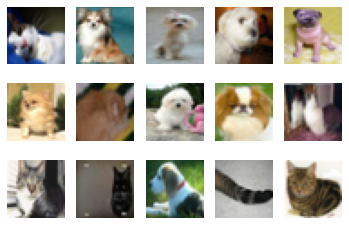

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

8000
2000
2000


There are 8000 training examples for the combined `cat` and `dog` classes.

There are 2000 validation examples for the combined `cat` and `dog` classes.

There are 2000 testing examples for the combined `cat` and `dog` classes.


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

We need a validation set to tune the hyperparameters of our model.

We also need it as an intermediate step between the training and testing data, so we do not overfit to our test data.

If we judge our performance on training loss/error we get inaccurate results because the model has trained on this data and knows the data. To test performance accurately we need to use validation/testing data that the model has not trained on.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
sum_small_net = 0
sum_large_net = 0
for param in small_net.parameters():
    sum_small_net += param.numel()
for param in large_net.parameters():
    sum_large_net += param.numel()
print(f'Total number of parameters in small_net = {sum_small_net}')
print(f'Total number of parameters in small_net = {sum_large_net}')

Total number of parameters in small_net = 386
Total number of parameters in small_net = 9705


There are `386` parameters in `small_net`.

There are `9705` parameters in `large_net`.

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

**The default values are:**

`batch_size` = 64

`learning_rate` = 0.01

`num_epochs` = 30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(small_net, batch_size=64, learning_rate=0.01, num_epochs=5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43275, Train loss: 0.6771031355857849 |Validation err: 0.3855, Validation loss: 0.657592635601759
Epoch 2: Train err: 0.3705, Train loss: 0.6465947608947754 |Validation err: 0.377, Validation loss: 0.6571690328419209
Epoch 3: Train err: 0.352, Train loss: 0.6316091046333313 |Validation err: 0.3485, Validation loss: 0.6237184684723616
Epoch 4: Train err: 0.341125, Train loss: 0.6186349420547486 |Validation err: 0.3475, Validation loss: 0.6229401733726263
Epoch 5: Train err: 0.33275, Train loss: 0.6113546528816223 |Validation err: 0.336, Validation loss: 0.6173702534288168
Finished Training
Total time elapsed: 22.85 seconds


**Files written to disk:**


1 /content/model_small_bs64_lr0.01_epoch4_train_err.csv

`.csv` file containing average classification error on the training data for each of the 5 epochs

2 /content/model_small_bs64_lr0.01_epoch4_train_loss.csv

`.csv` file containing the average loss function on the training data for each of the 5 epochs


3 /content/model_small_bs64_lr0.01_epoch4_val_err.csv

`.csv` file containing average classification error on the validation data for each of the 5 epochs


4 /content/model_small_bs64_lr0.01_epoch4_val_loss.csv

`.csv` file containing the average loss function on the validation data for each of the 5 epochs

5 /content/model_small_bs64_lr0.01_epoch0

file containing the current model (checkpoint) after the first epoch

6 /content/model_small_bs64_lr0.01_epoch1

file containing the current model (checkpoint) after the second epoch

7 /content/model_small_bs64_lr0.01_epoch2

file containing the current model (checkpoint) after the third epoch

8 /content/model_small_bs64_lr0.01_epoch3

file containing the current model (checkpoint) after the fourth epoch

9 /content/model_small_bs64_lr0.01_epoch4

file containing the current model (checkpoint) after the fifth epoch


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
print('small_net\n')
train_net(small_net, batch_size=64, learning_rate=0.01, num_epochs=30)
print('\nlarge_net\n')
train_net(large_net, batch_size=64, learning_rate=0.01, num_epochs=30)

small_net

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.32975, Train loss: 0.6050996339321136 |Validation err: 0.335, Validation loss: 0.6185032967478037
Epoch 2: Train err: 0.324, Train loss: 0.6005502343177795 |Validation err: 0.351, Validation loss: 0.6315443590283394
Epoch 3: Train err: 0.31575, Train loss: 0.596186460018158 |Validation err: 0.3255, Validation loss: 0.6051317490637302
Epoch 4: Train err: 0.311625, Train loss: 0.5916463265419006 |Validation err: 0.3285, Validation loss: 0.6101146396249533
Epoch 5: Train err: 0.30975, Train loss: 0.5877846229076386 |Validation err: 0.3235, Validation loss: 0.608112646266818
Epoch 6: Train err: 0.306375, Train loss: 0.5848837285041809 |Validation err: 0.3245, Validation loss: 0.6069805081933737
Epoch 7: Train err: 0.304875, Train loss: 0.5811685478687286 |Validation err: 0.3295, Validation loss: 0.6027823435142636
Epoch 8: Train err: 0.302125, Train loss: 0.5773657445907593 |Validat

`small_net` took `149.51` seconds to train.

`large_net` took longer `163.41` seconds to train.

`large_net` took longer to train because there are more computations needed (gradient, loss, activation) due to having more neurons.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

Curves for small_net



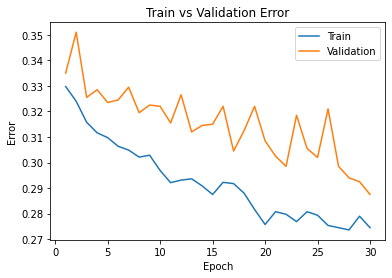

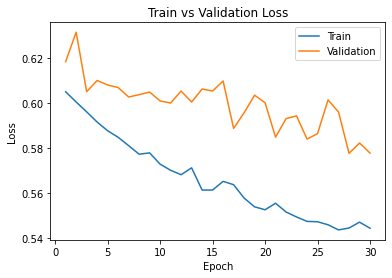


Curves for large_net



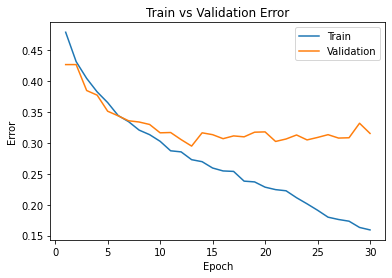

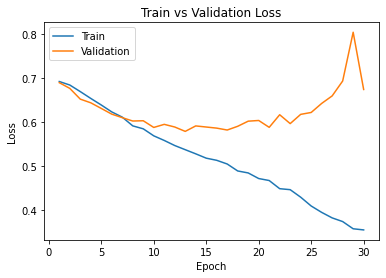

In [ ]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
print('Curves for small_net\n')
plot_training_curve(model_path)
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
print('\nCurves for large_net\n')
plot_training_curve(model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

1 `small_net`

The error and the loss start at high values for both the training and the validation data, for a low number of epochs. The error decreases for both the training and validation data as the number of epochs increases. The loss also decreases for both the training and validation data as the number of epochs increases.

The error and loss for the validation data is always higher than the error and loss for the training data.

2 `large_net`

Similar to `small_net`, the error and the loss start at high values for both the training and the validation data, for a low number of epochs. The training error monotonically decreases as the number of epochs increases. However, differently from `small_net`, the validation error decreases and then plateaus for increasing number of epochs.
The training loss monotonically decreases as the number of epochs increases. However, the validation loss initially decreases and then starts to increase again after around 15 epochs.

We can see some overfitting occuring in `large_net`. The training error and loss decreases to a very low value, but the validation error and loss is high. This is because the model is memorizing the training data as the number of epochs is too high.

We are able to achieve lower validation error and loss at the end of the 30 epochs using `small_net`.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

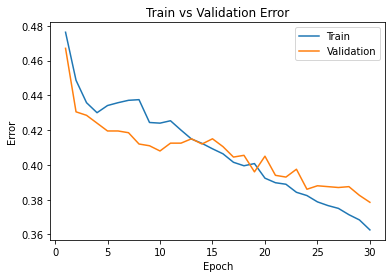

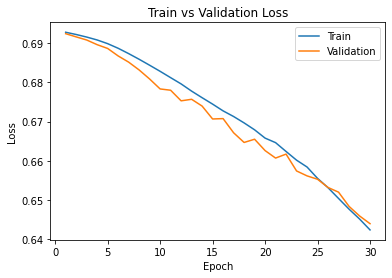

In [ ]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

The model takes longer to train for smaller learning rate.

Decreasing the learning rate decreases the step size for each iteration of the gradient descent. This decreases the amount by which the weights are changed for each iteration. Thus, the weights take longer to reach an optimum.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [ ]:
train_net(large_net, batch_size=64, learning_rate=0.1, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.38775, Train loss: 0.6537635383605958 |Validation err: 0.333, Validation loss: 0.6193162687122822
Epoch 2: Train err: 0.353875, Train loss: 0.6262839932441712 |Validation err: 0.3565, Validation loss: 0.6403095405548811
Epoch 3: Train err: 0.34075, Train loss: 0.6136966214179993 |Validation err: 0.3385, Validation loss: 0.6106533501297235
Epoch 4: Train err: 0.326125, Train loss: 0.6020211086273194 |Validation err: 0.3465, Validation loss: 0.6345503106713295
Epoch 5: Train err: 0.330375, Train loss: 0.5990978620052337 |Validation err: 0.356, Validation loss: 0.6229809932410717
Epoch 6: Train err: 0.305625, Train loss: 0.5728513960838317 |Validation err: 0.3165, Validation loss: 0.6288244863972068
Epoch 7: Train err: 0.302625, Train loss: 0.5691495106220246 |Validation err: 0.327, Validation loss: 0.6216712752357125
Epoch 8: Train err: 0.296875, Train loss: 0.5625165519714356 |Validation er

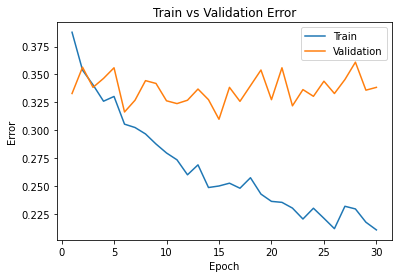

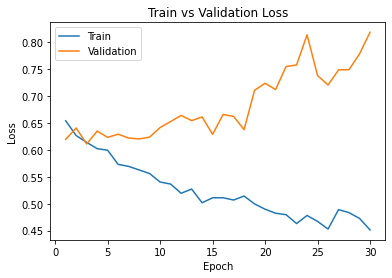

In [ ]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path)

The model takes shorter to train for a larger learning rate.

Increasing the learning rate increases the step size which causes a bigger change in the weights in each iteration. Thus, the weights will converge to an optimum faster.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [ ]:
train_net(large_net, batch_size=512, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.217, Train loss: 0.442996259778738 |Validation err: 0.3315, Validation loss: 0.805944487452507
Epoch 2: Train err: 0.204625, Train loss: 0.4111692141741514 |Validation err: 0.329, Validation loss: 0.8029888421297073
Epoch 3: Train err: 0.192125, Train loss: 0.38936517760157585 |Validation err: 0.3255, Validation loss: 0.8103515356779099
Epoch 4: Train err: 0.18075, Train loss: 0.37405015900731087 |Validation err: 0.321, Validation loss: 0.8224472403526306
Epoch 5: Train err: 0.175875, Train loss: 0.3618528749793768 |Validation err: 0.3135, Validation loss: 0.8349554985761642
Epoch 6: Train err: 0.170125, Train loss: 0.3520508799701929 |Validation err: 0.3115, Validation loss: 0.8515031486749649
Epoch 7: Train err: 0.163375, Train loss: 0.3443938735872507 |Validation err: 0.309, Validation loss: 0.8648639917373657
Epoch 8: Train err: 0.161125, Train loss: 0.3358039129525423 |Validation err:

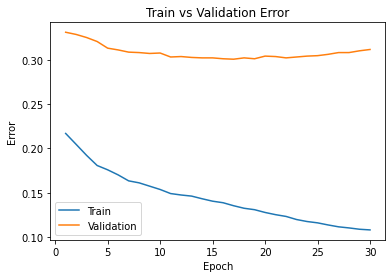

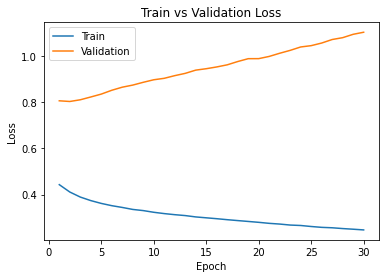

In [ ]:
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

The model takes shorter to train for a larger batch size.

Increasing the batch size is computationally more expensive. Also, the average loss might not change very much from iteration to iteration as the batch size grows.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [ ]:
train_net(large_net, batch_size=16, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.1375, Train loss: 0.301403375826776 |Validation err: 0.3185, Validation loss: 1.0299265325069427
Epoch 2: Train err: 0.119125, Train loss: 0.2696600869596005 |Validation err: 0.3165, Validation loss: 1.152799193263054
Epoch 3: Train err: 0.11425, Train loss: 0.2549446198567748 |Validation err: 0.317, Validation loss: 1.2684097901582718
Epoch 4: Train err: 0.100875, Train loss: 0.22989950079470872 |Validation err: 0.3155, Validation loss: 1.3218068065643311
Epoch 5: Train err: 0.086, Train loss: 0.20312492079567165 |Validation err: 0.3145, Validation loss: 1.434038190126419
Epoch 6: Train err: 0.085, Train loss: 0.19460190909169614 |Validation err: 0.3235, Validation loss: 1.7952125098705292
Epoch 7: Train err: 0.082875, Train loss: 0.19793180222972295 |Validation err: 0.3215, Validation loss: 1.7033880808353423
Epoch 8: Train err: 0.084125, Train loss: 0.19621943324338645 |Validation err: 

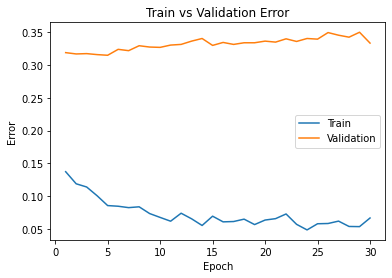

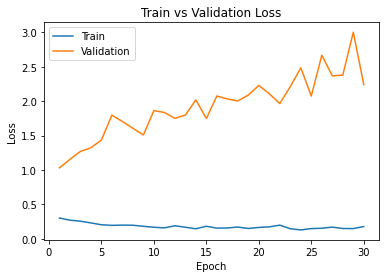

In [ ]:
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

The model takes longer to train for a smaller batch size.

Decreasing the batch size can cause the loss to vary by large amounts from iteration to iteration. Thus, the optimization becomes similar to a Stochastic Gradient Descent.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

I noticed that the validation error and loss was monotonically decreasing for a smaller learning rate of 0.001, so I chose this value.

I also noticed that the validation error and loss for the small neural network was generally smaller than that of the large neural network. Thus, I chose a small neural network instead.

In [ ]:
train_net(small_net, batch_size=64, learning_rate=0.001, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.263125, Train loss: 0.5268839533329011 |Validation err: 0.2905, Validation loss: 0.5755969630554318
Epoch 2: Train err: 0.258875, Train loss: 0.5256966726779938 |Validation err: 0.285, Validation loss: 0.572457417845726
Epoch 3: Train err: 0.258625, Train loss: 0.525396712064743 |Validation err: 0.2845, Validation loss: 0.5732061583548784
Epoch 4: Train err: 0.260375, Train loss: 0.5250336794853211 |Validation err: 0.2895, Validation loss: 0.5736876595765352
Epoch 5: Train err: 0.25675, Train loss: 0.5252161192893982 |Validation err: 0.286, Validation loss: 0.5761817991733551
Epoch 6: Train err: 0.26225, Train loss: 0.5247534024715423 |Validation err: 0.284, Validation loss: 0.5826646564528346
Epoch 7: Train err: 0.257875, Train loss: 0.525278000831604 |Validation err: 0.285, Validation loss: 0.5715963253751397
Epoch 8: Train err: 0.26, Train loss: 0.5237828547954559 |Validation err: 0.285

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

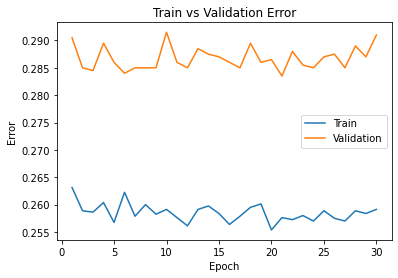

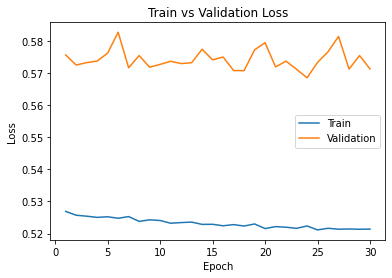

In [ ]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

The result from Part(a) at epoch 24 gave the smallest validation loss/error so far. Thus, I know I am going in the right direction so I stayed with the small neural network.

None of the other hyperparameters seem to be giving better validation accuracy, so I will try to decrease the learning rate further, as that has shown to increase the accuracy based on previous plots.

In [ ]:
train_net(small_net, batch_size=64, learning_rate=0.0005, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.25875, Train loss: 0.5201393849849701 |Validation err: 0.2855, Validation loss: 0.5718713533133268
Epoch 2: Train err: 0.256875, Train loss: 0.5196348538398743 |Validation err: 0.287, Validation loss: 0.569041283801198
Epoch 3: Train err: 0.25525, Train loss: 0.5196651833057404 |Validation err: 0.2875, Validation loss: 0.5706487596035004
Epoch 4: Train err: 0.256375, Train loss: 0.5195232543945313 |Validation err: 0.2865, Validation loss: 0.5703267017379403
Epoch 5: Train err: 0.2565, Train loss: 0.5197879240512848 |Validation err: 0.285, Validation loss: 0.5731260823085904
Epoch 6: Train err: 0.260625, Train loss: 0.5197679588794708 |Validation err: 0.283, Validation loss: 0.5797447571530938
Epoch 7: Train err: 0.258, Train loss: 0.5198904554843903 |Validation err: 0.2855, Validation loss: 0.569829173386097
Epoch 8: Train err: 0.257, Train loss: 0.5192551956176757 |Validation err: 0.282, 

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

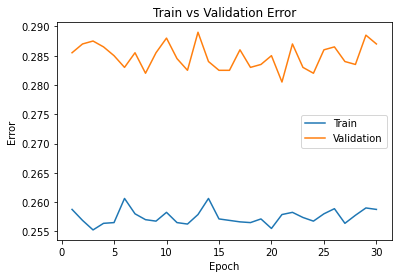

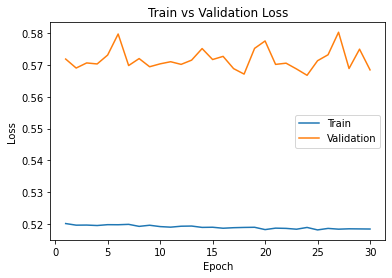

In [ ]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.0005, epoch=29)
plot_training_curve(model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = SmallNet()
model_path = get_model_name(net.name, batch_size=64, learning_rate=0.0005, epoch=23)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

I chose this model because it gave the lowest validation error/loss out of all the models that I trained.

`Validation error: 0.282, Validation loss: 0.5667562345042825`

I decreased the learning rate due to the trend I noticed in Part(3)(a). I chose the small neural network due to the trend I noticed in Part(2)(e).



### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=64)

# computing the test error and loss
test_err, test_loss = evaluate(net, test_loader, nn.BCEWithLogitsLoss())
print("Test err: {}, Test loss: {}".format(test_err, test_loss))

Files already downloaded and verified
Files already downloaded and verified
Test err: 0.2845, Test loss: 0.5502729788422585


Test classification error = `0.2845`



### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

The test classification error is higher than the validation error.

We expect the test error to be higher because the test data consists of samples that the model has never seen before. Thus, the model will make more mistakes on the test data than on the validation data, which it has seen and learnt to an extent from tuning the hyperparameters.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

We only use the test data until the very end because we want to use it to evaluate the model's performance on data that it has never seen before.

We also want to make sure that our model doesn't overfit to the test data.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43875, Train loss: 0.683259033203125 |Validation err: 0.4305, Validation loss: 0.6766680255532265
Epoch 2: Train err: 0.407125, Train loss: 0.6690951929092407 |Validation err: 0.419, Validation loss: 0.6681596878916025
Epoch 3: Train err: 0.395875, Train loss: 0.661951105594635 |Validation err: 0.4125, Validation loss: 0.6638330724090338
Epoch 4: Train err: 0.3895, Train loss: 0.6570034880638123 |Validation err: 0.408, Validation loss: 0.6593983452767134
Epoch 5: Train err: 0.384625, Train loss: 0.6529391293525696 |Validation err: 0.4045, Validation loss: 0.658543361350894
Epoch 6: Train err: 0.38, Train loss: 0.6492581810951233 |Validation err: 0.3965, Validation loss: 0.6568431053310633
Epoch 7: Train err: 0.37425, Train loss: 0.6462045841217041 |Validation err: 0.3935, Validation loss: 0.6549235824495554
Epoch 8: Train err: 0.374, Train loss: 0.6433852443695068 |Validation err: 0.391, V

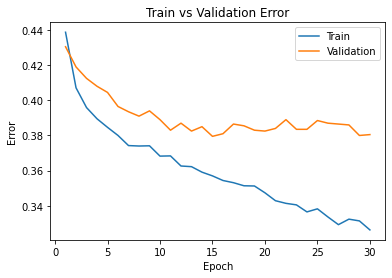

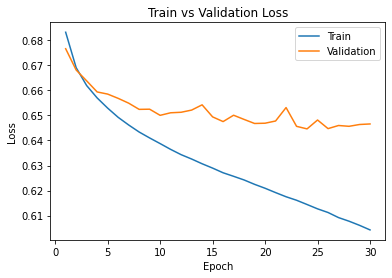

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

def test_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

# defining a 2-layer neural netowrk
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.name = 'ann'
        self.layer1 = nn.Linear(3*32*32, 30)
        self.layer2 = nn.Linear(30, 1)

    def forward(self, img):
        flattened = img.view(-1, 32*32*3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2.squeeze(1)

model = NN()

# training and testing the ANN model
def ann_train_and_test(ann, batch_size, learning_rate, epochs):
  # training
  train_net(model, batch_size, learning_rate, epochs)
  train_loader, val_loader, test_loader, classes = get_data_loader(target_classes=["cat", "dog"], batch_size = batch_size)
  # testing
  test_err, test_loss = evaluate(ann, test_loader, nn.BCEWithLogitsLoss())
  print("Test err: {}, Test loss: {}".format(test_err, test_loss))
  # Save the current model (checkpoint) to a file
  model_path = test_name(ann.name, batch_size, learning_rate, epochs - 1)
  torch.save(ann.state_dict(), model_path)
  plot_training_curve(model_path)

ann_train_and_test(model, 64, 0.0005, 30)

The best CNN model performs better than the ANN model in classifying cats and dogs.

For the ANN: `Test error: 0.3505, Test loss: 0.6385042406618595`

For the best CNN: `Test err: 0.2845, Test loss: 0.5502729788422585`